In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import os 
import shutil
import random
import matplotlib.pyplot as plt
from PIL import Image  # Import for image resizing
%matplotlib inline

In [2]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Paths
dataset_folder = r'C:\Users\moham\Desktop\computer vision\sign language digits dataset'  # Replace with your dataset folder path

# Define split ratios
train_split = 0.7
valid_split = 0.2
test_split = 0.1

# Create ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,  # Preprocessing function for MobileNet
)

#valid_test_datagen = ImageDataGenerator(   preprocessing_function=tf.keras.applications.mobilenet.preprocess_input  # Only apply preprocessing for validation and test
#)

# Set target size for resizing images
target_size = (224, 224)
batch_size = 32

# Create train, valid, test folders at the dataset level
train_folder = os.path.join(dataset_folder, 'train')
valid_folder = os.path.join(dataset_folder, 'valid')
test_folder = os.path.join(dataset_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Process each class folder (0-9)
for folder_name in range(10):
    class_folder = os.path.join(dataset_folder, str(folder_name))
    images = os.listdir(class_folder)
    
    # Split the images into train, valid, and test sets
    train_images, temp_images = train_test_split(images, test_size=(1 - train_split), random_state=42)
    valid_images, test_images = train_test_split(temp_images, test_size=(test_split / (valid_split + test_split)), random_state=42)
    
    # Create subdirectories in train, valid, test for each class (0-9)
    train_class_folder = os.path.join(train_folder, str(folder_name))
    valid_class_folder = os.path.join(valid_folder, str(folder_name))
    test_class_folder = os.path.join(test_folder, str(folder_name))
    
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(valid_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)
    
    # Move images to the corresponding train, valid, test class folders
    for image in train_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(train_class_folder, image))
    
    for image in valid_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(valid_class_folder, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_folder, image), os.path.join(test_class_folder, image))

print("Images successfully distributed into train, valid, and test folders.")

# Create batches for train, valid, and test data
train_batch = train_datagen.flow_from_directory(
    train_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you are dealing with a classification problem
    shuffle=True
)

valid_batch = train_datagen.flow_from_directory(
    valid_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_batch = train_datagen.flow_from_directory(
    test_folder,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Train, valid, and test batches ready.")


Images successfully distributed into train, valid, and test folders.
Found 1438 images belonging to 10 classes.
Found 414 images belonging to 10 classes.
Found 210 images belonging to 10 classes.
Train, valid, and test batches ready.


In [11]:
x_train, y_train = next(train_batch)
print(x_train.shape, y_train.shape)

x_valid, y_valid = next(valid_batch)
print(x_valid.shape, y_valid.shape)


(32, 224, 224, 3) (32, 10)
(32, 224, 224, 3) (32, 10)


In [4]:
mobilenet = tf.keras.applications.mobilenet.MobileNet()
mobilenet.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [5]:
x = mobilenet.layers[-6].output
x

<KerasTensor shape=(None, 7, 7, 1024), dtype=float32, sparse=False, name=keras_tensor_85>

In [6]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(x)  # Convert (None, 1, 1, 1024) -> (None, 1024)
output = Dense(10, activation = 'softmax')(x)


In [7]:
model = Model(inputs = mobilenet.input , outputs = output )
for layer in model.layers[:-23]:
    layer.trainable = False

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 1,873,930 (7.15 MB)

 Non-trainable params: 1,365,184 (5.21 MB)

In [15]:
steps_per_epoch = 1438 // 32  # total_train_images // batch_size
validation_steps = 414 // 32  # total_validation_images // batch_size

In [16]:
model.compile(optimizer='Adam', loss = "categorical_crossentropy",metrics = ['accuracy'])

In [17]:
model.fit(
    x=train_batch,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_batch,
    epochs=29,
    validation_steps=validation_steps,
    verbose=1
)


Epoch 1/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.9377 - loss: 0.1926 - val_accuracy: 0.2214 - val_loss: 4.4882
Epoch 2/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.2000 - val_loss: 4.8621
Epoch 3/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 710ms/step - accuracy: 0.9545 - loss: 0.1282 - val_accuracy: 0.7370 - val_loss: 0.8386
Epoch 4/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0508 - val_accuracy: 0.7000 - val_loss: 0.7639
Epoch 5/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 721ms/step - accuracy: 0.9788 - loss: 0.0765 - val_accuracy: 0.9401 - val_loss: 0.2013
Epoch 6/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9000 - val_loss: 0.2265
Epoch 7/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 718ms/step - accuracy: 0.9836 - loss: 0.0481 - val_accuracy: 0.9922 - val_loss: 0.0281
Epoch 8/29
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0

In [18]:
test_lable = test_batch.classes
test_lable

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [19]:
predictions = model.predict(x=test_batch,steps=len(test_batch),verbose=0)

C:\Users\moham\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [21]:
cm = confusion_matrix(y_true = test_lable,y_pred=predictions.argmax(axis=1))
cm

array([[19,  1,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0, 21,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 17,  0,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 18,  0,  1,  0,  1,  1],
       [ 0,  0,  0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 21,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 20,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 20]], dtype=int64)

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_batch, verbose=1)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.9493 - loss: 0.1517
Test Loss: 0.1257506012916565, Test Accuracy: 0.9571428298950195


In [23]:
# Generate predictions for the test images
test_batch.reset()  # Reset the generator to avoid sequence issues
predictions = model.predict(test_batch, verbose=1)

# Convert predictions from one-hot encoding to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the test dataset
true_classes = test_batch.classes

# Get the class labels (this is optional, for better understanding of output)
class_labels = list(test_batch.class_indices.keys())


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step


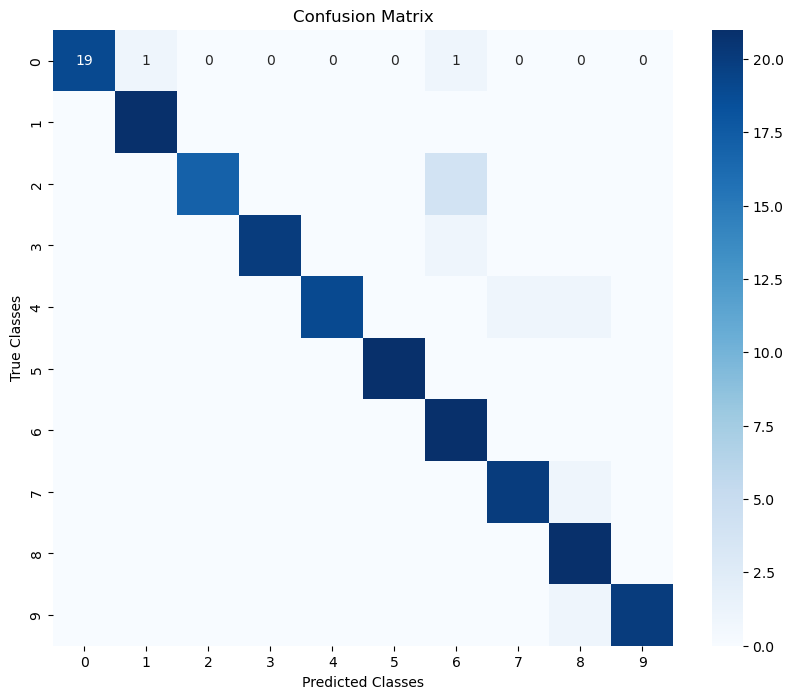

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


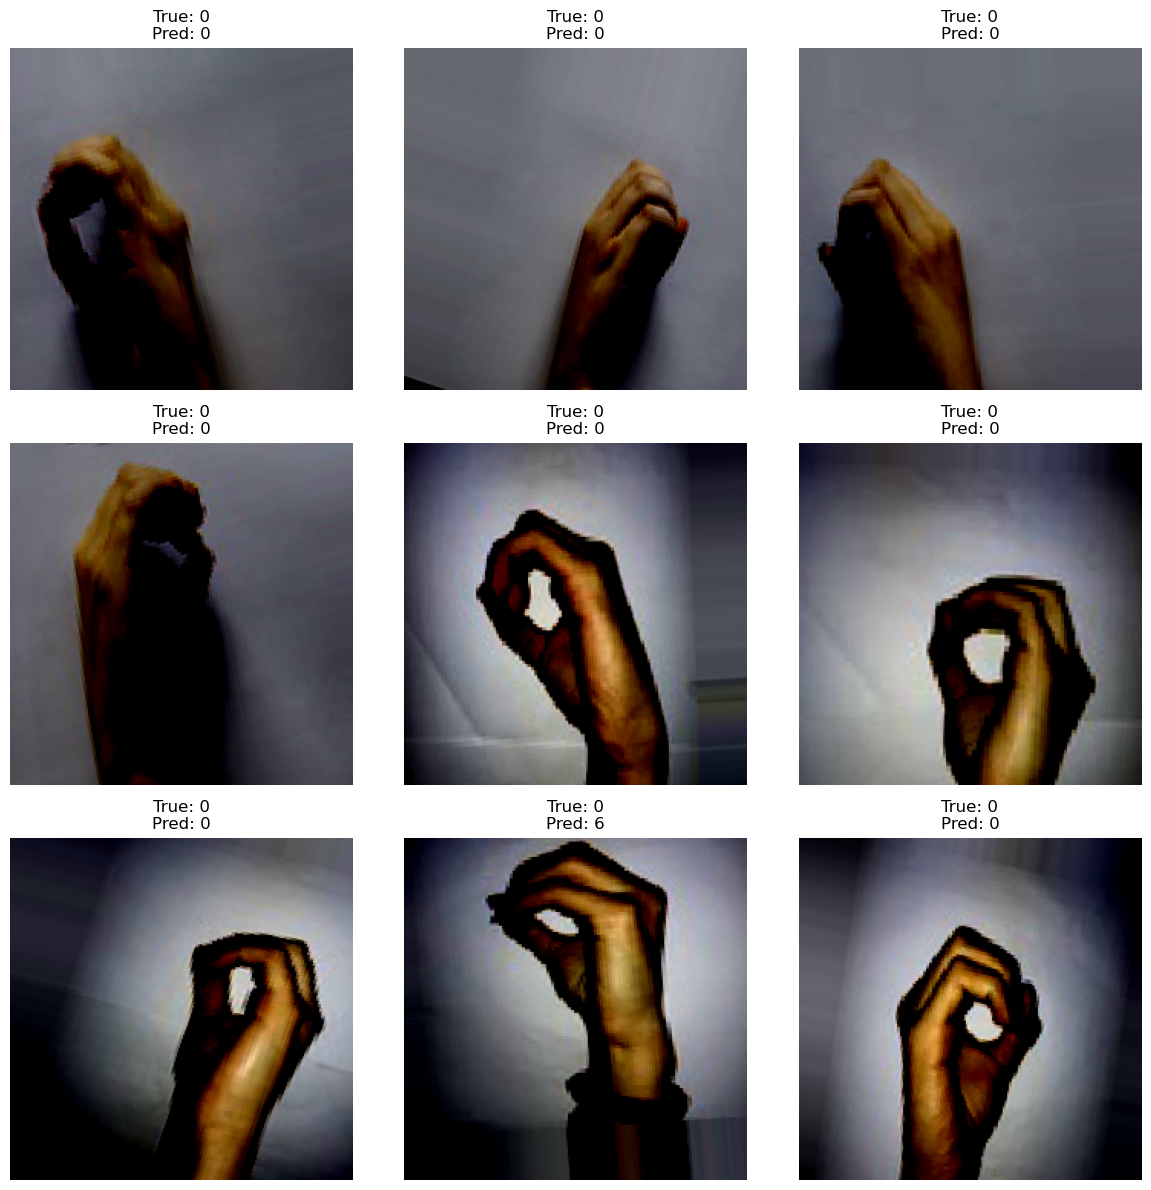

Display next batch? (yes/no):  yes


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


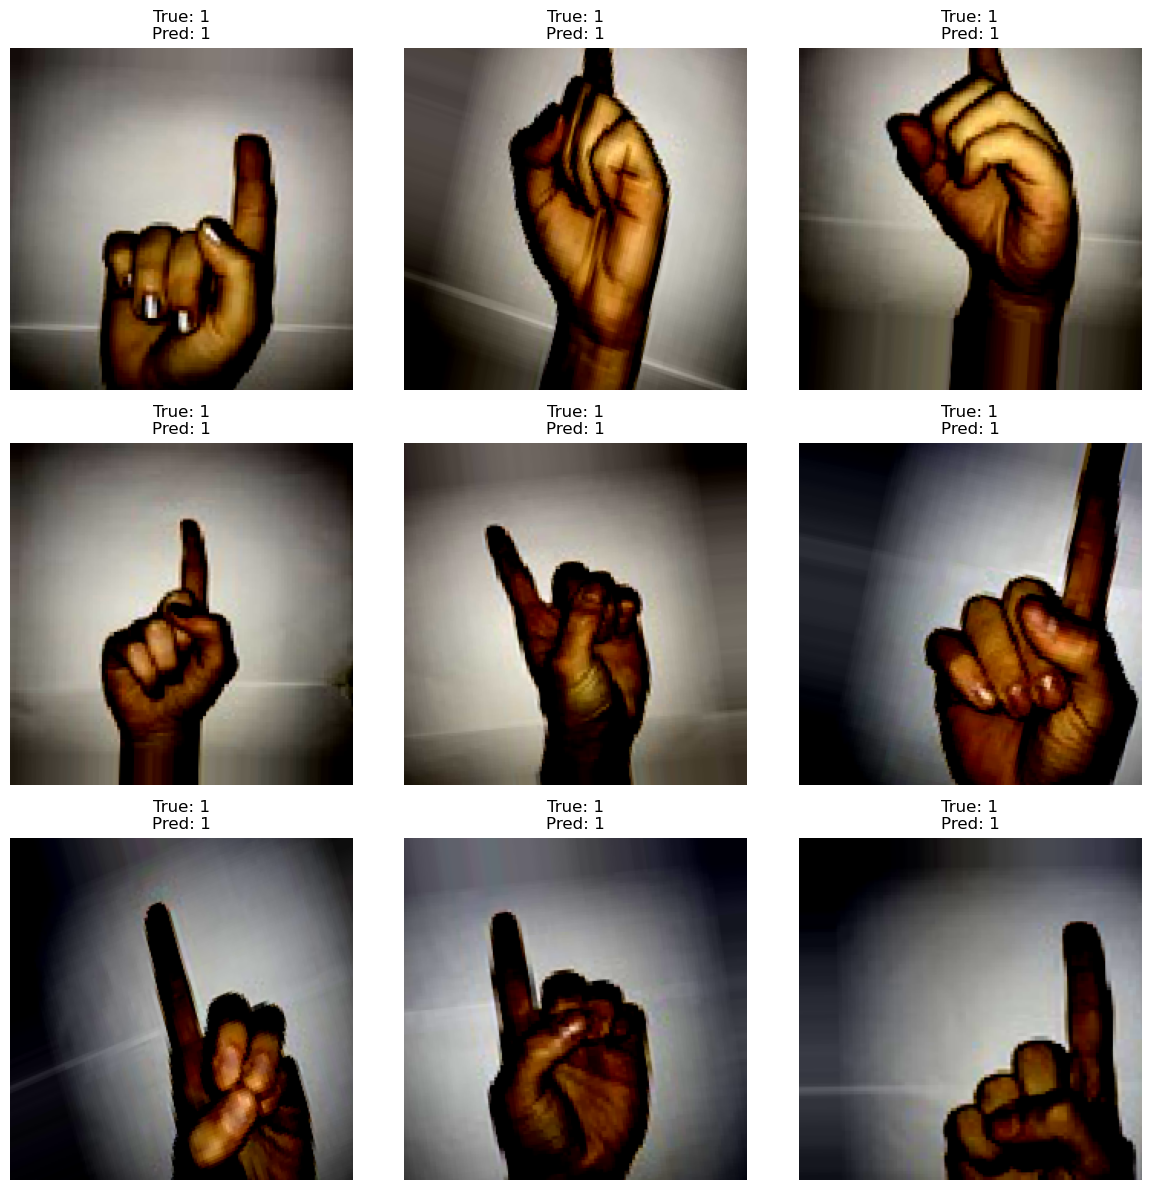

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display a batch of test images along with predicted and true labels
def display_test_images(batch_size=9):
    # Reset the generator to start from the first batch if needed
    test_batch.reset()

    # Iterate through the test dataset in batches
    for batch_num in range(len(test_batch)):  # Loop through each batch
        x_test, y_test = next(test_batch)  # Get the next batch of images and labels

        # Generate predictions for the current batch
        predictions = model.predict(x_test)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(y_test, axis=1)

        # Plot the images along with true and predicted labels
        plt.figure(figsize=(12, 12))
        for i in range(min(batch_size, len(x_test))):  # Display a fixed number of images
            plt.subplot(3, 3, i+1)
            plt.imshow(x_test[i])
            true_label = class_labels[true_classes[i]]
            predicted_label = class_labels[predicted_classes[i]]
            plt.title(f'True: {true_label}\nPred: {predicted_label}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

        # Ask the user if they want to display more images
        user_input = input("Display next batch? (yes/no): ").strip().lower()
        if user_input != 'yes':
            break

# Call the function to display test images
display_test_images(batch_size=9)
